# HAWC+ Data Analysis Techniques

In this jupyter cookbook, we will explore the [HAWC+](https://www.sofia.usra.edu/science/instruments/hawc) data cube and describe some of the basic analysis techniques involving imaging polarimetry data.

This cookbook follows the SOFIA press release of 30 Doradus observations: [SOFIA Reveals Never-Before-Seen Magnetic Field Details](https://www.sofia.usra.edu/multimedia/science-results-archive/sofia-reveals-never-seen-magnetic-field-details).

The Level 4 reduced data from this program has been released immediately to the public and is available on the [SOFIA Data Cycle System (DCS)](https://dcs.sofia.usra.edu/).  This notebook will guide the reader through downloading the 30 Doradus data with a walkthrough of basic analysis techniques with `python`.

# Downloading HAWC+ Data

- If you do not yet have a DCS account, register for one at [https://dcs.sofia.usra.edu/userSupport/registration.jsp](https://dcs.sofia.usra.edu/userSupport/registration.jsp)
- Log into DCS: [https://dcs.sofia.usra.edu](https://dcs.sofia.usra.edu)
- Go to [Search Science Archive](https://dcs.sofia.usra.edu/dataRetrieval/SearchScienceArchiveInfoBasic.jsp)
- Fill in:
  - Instrument: `HAWC_PLUS` from drop-down menu
  - Processing State: `LEVEL_4` from drop-down menu
  - Target: 30Dor (No need to resolve the name via Simbad or NED. If resolved use a large search radius, e.g. 600")
  - Click the `Submit` button
- After the results load, select the checkboxes next to each of the six rows of the table.
- Click `Get Selected Data in Current Page`
- Click `Request Data Bundle`
- After a few minutes, an email with a download link will be sent to the email address associated with your DCS account.
- For more information, consult the HAWC+ Data Handbook accessible at [https://www.sofia.usra.edu/science/proposing-and-observing/data-products/data-resources](https://www.sofia.usra.edu/science/proposing-and-observing/data-products/data-resources)

# SOFIA Data Organization
After downloading the SOFIA DCS bundle to your working directory you will want to unzip it, which will produce a directory structure like this:

Note that each file represents observations with a different filter.  However, two observations were made with the same filter (HAWC C, $89\,\mathrm{\mu m}$).  These files, `F0483_HA_POL_7600014_HAWCHWPC_PMP_022-065.fits` and `F0484_HA_POL_7600017_HAWCHWPC_PMP_065-114.fits`, were combined into one: `level4->p5813->F0484_HA_POL_7600018_HAWCHWPC_PMP_022-114.fits`.

You can choose to keep the `fits` files nested, or copy them into one directory.  **[remove this]** If you are feeling particularly courageous, the following `bash` command will flatten the current directory structure for you.

```console
foo@bar:~$ find . -mindepth 3 -type f -exec cp -i '{}' . ';'
```

For the purpose of this basic analysis, though, let us dump all the files into one `sofia_data` directory:

# Data Structure

For this analysis, we require the standard [numpy/scipy/matplotlib stack](https://scipy.org/install.html) as well the [astropy](http://docs.astropy.org/en/stable/) modules.

With just a few lines of code, we can explore the HAWC+ `fits` data cubes and plot the images.

In [1]:
from astropy.io import fits

filename = 'sofia_data/F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits'
hawc = fits.open(filename)
hawc.info()

Filename: sofia_data/F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  STOKES I      1 PrimaryHDU     572   (94, 114)   float64   
  1  ERROR I       1 ImageHDU        27   (94, 114)   float64   
  2  STOKES Q      1 ImageHDU        18   (94, 114)   float64   
  3  ERROR Q       1 ImageHDU        18   (94, 114)   float64   
  4  STOKES U      1 ImageHDU        18   (94, 114)   float64   
  5  ERROR U       1 ImageHDU        18   (94, 114)   float64   
  6  IMAGE MASK    1 ImageHDU        27   (94, 114)   float64   
  7  PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
  8  DEBIASED PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
  9  ERROR PERCENT POL    1 ImageHDU        18   (94, 114)   float64   
 10  POL ANGLE     1 ImageHDU        18   (94, 114)   float64   
 11  ROTATED POL ANGLE    1 ImageHDU        18   (94, 114)   float64   
 12  ERROR POL ANGLE    1 ImageHDU        18   (94, 114)   float

We can see above the data structure of the multi-extension `fits` files.  Each file contains 19 extensions which encapsulates all of the Stokes parameters in a single package.

## Stokes I
Stokes $I$---the zeroth extension in the `fits` file---represents the total intensity of the image, where $I^2 = Q^2 + U^2$.


Let us go ahead and plot this extension:

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook
# ^jupyter magic for inline plots
#plt.rcParams['image.cmap'] = 'plasma'
from astropy.wcs import WCS
import numpy as np

stokes_i = hawc['STOKES I']            # or hawc[0]. Note the ext name is from the hawc.info() table above
stokes_i.wcs = WCS(stokes_i.header)    # read the WCS information from the header
                                       #  and store it in stokes_i.wcs

plt.figure()
axi = plt.subplot(projection=stokes_i.wcs)
plt.imshow(stokes_i.data, origin='lower')    # 'lower' here specifies that the image array is ordered
                                             #    from the lower-left to the top-right (fits/ds9 style)
                                             #    vs. top-left to lower-right (numpy style)

# FORMATTING
axi.set_title('Stokes I')
axi.set_xlabel(r'$\alpha_{2000}$')
axi.set_ylabel(r'$\delta_{2000}$')
axi.coords[0].set_major_formatter('hh:mm:ss')

<IPython.core.display.Javascript object>

The only important pieces of code here are reading the extension:
- ```python
stokes_i = hawc['STOKES I']
```

and plotting the data
- ```python
plt.imshow(stokes_i.data, origin='lower')
```

The rest is essentially for formatting `matplotlib` to display the WCS information in the headers.  For more detailed instructions on this process, see the `WCSAxes` documentation at [http://docs.astropy.org/en/stable/visualization/wcsaxes/index.html](http://docs.astropy.org/en/stable/visualization/wcsaxes/index.html).

## Stokes Q and U
Similarly, we can plot the Stokes Q and Stokes U images:

<IPython.core.display.Javascript object>


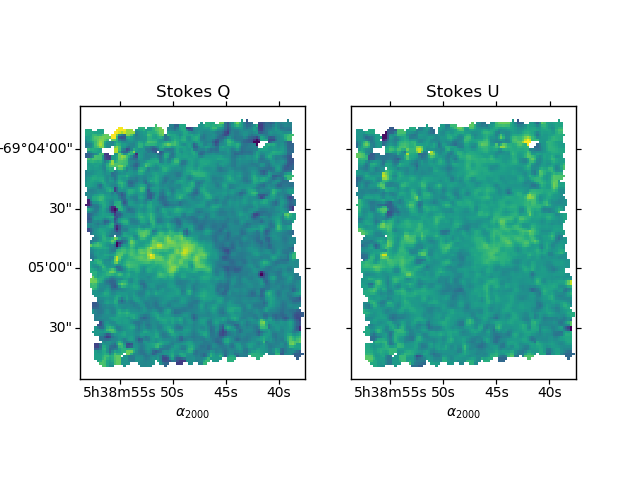

In [3]:
stokes_q = hawc['STOKES Q']
stokes_q.wcs = WCS(stokes_q.header)

stokes_u = hawc['STOKES U']
stokes_u.wcs = WCS(stokes_u.header)

plt.figure()
axq = plt.subplot(1,2,1, projection=stokes_q.wcs)
axu = plt.subplot(1,2,2, projection=stokes_u.wcs,sharex=axq,sharey=axq)  # shared so the axes zoom together
axq.imshow(stokes_q.data,origin='lower')
axu.imshow(stokes_u.data,origin='lower')

# FORMATTING
axq.set_title('Stokes Q')
axu.set_title('Stokes U')
axq.set_xlabel(r'$\alpha_{2000}$')
axq.set_ylabel(r'$\delta_{2000}$')
axu.set_xlabel(r'$\alpha_{2000}$')
axq.coords[0].set_major_formatter('hh:mm:ss')
axu.coords[0].set_major_formatter('hh:mm:ss')
axu.coords[1].set_ticklabel_visible(False)

We can additionally plot the associated error maps for each extension. **[are the units for error in Jy/pixel or are they a percentage?]**

<IPython.core.display.Javascript object>


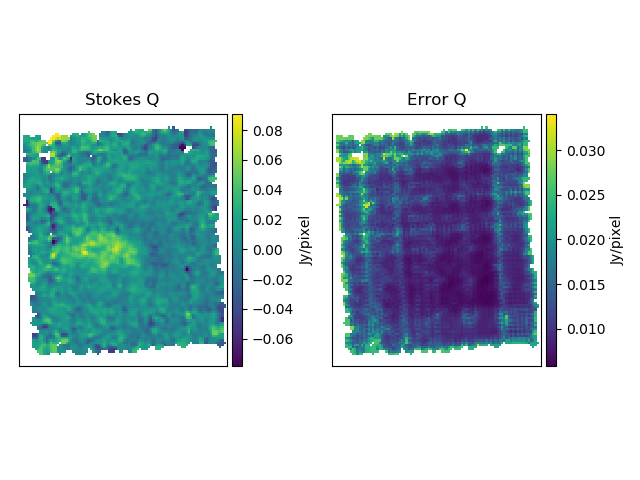

In [4]:
error_q = hawc['Error Q']

fig = plt.figure()
axq = plt.subplot(1,2,1)
axe = plt.subplot(1,2,2,sharex=axq,sharey=axq)

imq = axq.imshow(stokes_q.data,origin='lower')
ime = axe.imshow(error_q.data,origin='lower')

# FORMATTING
axq.set_title('Stokes Q')
axe.set_title('Error Q')

for ax in (axq,axe):
    # Hide axis labels
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

# Helper function for better-looking colorbars
from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(fig, ax, im, side='right',size='5%',pad=0.05,label=None):
    # just a wrapper for a series of matplotlib functions
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(side,size=size,pad=pad)
    bar = fig.colorbar(im,cax=cax)
    if label:
        bar.set_label(label)
    return bar

# Read units from STOKES I header
bunit = stokes_i.header['BUNIT']  # usually Jy/pixel--same for every calibrated image extension
add_colorbar(fig,axq,imq,label=bunit)
add_colorbar(fig,axe,ime,label=bunit)
plt.tight_layout()

## Polarized Intensity $I_p$
Level 4 HAWC+ additionally provides extensions with the polarization percentage ($p$), angle ($\theta$), and their associated errors ($\sigma$).

Percent polarization ($p$) and error ($\sigma_p$) are calculated as:

$p = 100\sqrt{\left(\frac{Q}{I}\right)^2+\left(\frac{U}{I}\right)^2}$

$\sigma_p = \frac{100}{I}\sqrt{\frac{1}{(Q^2+U^2)}\left[(Q\,\sigma_Q)^2+(U\,\sigma_U)^2+2QU\,\sigma_{QU}\right]+\left[\left(\frac{Q}{I}\right)^2+\left(\frac{U}{I}\right)^2\right]\sigma_I^2-2\frac{Q}{I}\sigma_{QI}-2\frac{U}{I}\sigma_{UI}}$ .

Note that $p$ here represents the **percent** polarization as opposed to the more typical convention for $p$ as the **fractional** polarization.

Maps of these data are found in extensions 7 (PERCENT POL) and 9 (ERROR PERCENT POL).

Polarized intensity, $I_p$, can then be calculated as $I_p = \frac{I\times p}{100}$, which is included in extension 13 (POL FLUX).

Also included is the debiased polarization percentage ($p^\prime$) calculated as:

$p^\prime=\sqrt{p^2-\sigma_p^2}$, found in extension 8 (DEBIASED PERCENT POL).

We similarly define the debiased polarized intensity as $I_{p^\prime} = \frac{I\times p^\prime}{100}$, which is included in extension 15 (DEBIASED POL FLUX).

<IPython.core.display.Javascript object>


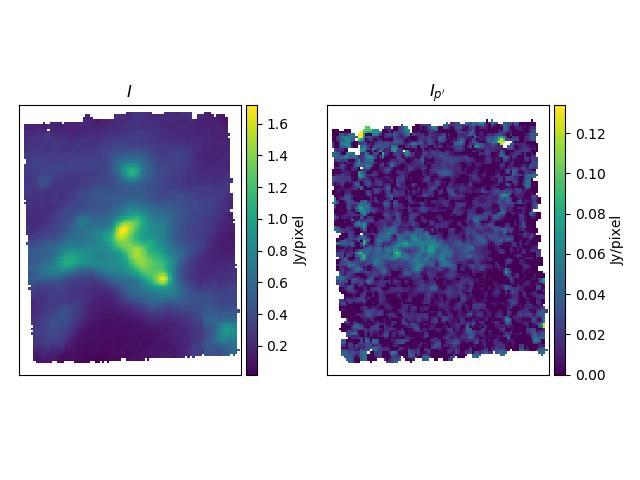

In [5]:
stokes_ip = hawc['DEBIASED POL FLUX']

fig = plt.figure()
axi = plt.subplot(1,2,1)
axp = plt.subplot(1,2,2,sharex=axi,sharey=axi)

imi = axi.imshow( stokes_i.data, origin='lower')
imp = axp.imshow(stokes_ip.data, origin='lower')

# FORMATTING
axi.set_title(r'$I$')
axp.set_title(r'$I_{p^\prime}$')

for ax in (axi,axp):
    # Hide axis labels
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

# add colorbar using function defined above
add_colorbar(fig,axi,imi, label=bunit)
add_colorbar(fig,axp,imp, label=bunit)
plt.tight_layout()

# Plotting Polarization Vectors

From the $Q$ and $U$ maps, the polarization angle $\theta$ is calculated in the standard way:

$\theta = \frac{90}{\pi}\,\mathrm{tan^{-1}}\left(\frac{U}{Q}\right)$

with associated error:

$\sigma_\theta = \frac{90}{\pi\left(Q^2+U^2\right)}\sqrt{\left(Q\sigma_Q\right)^2+\left(U\sigma_U\right)^2-2QU\sigma_{QU}}$

The angle map is stored in extension 10 (POL ANGLE), with its error in extension 12 (ERROR POL ANGLE).  

However, these angles are relative to detector coordinates.  The angle we are more interested in is the angle on the sky.  As part of the HAWC+ reduction pipeline, $\theta$ is corrected for the vertical position angle of the instrument on the sky, the angle of the HWP plate, as well as an offset angle that is calibrated to each filter configuration.  This correction angle is applied to $\theta\rightarrow\theta^\prime$ and is saved to extension 11 (ROTATED POL ANGLE).  This also affects the Stokes $Q$ and $U$ parameters, and so this factor has already been rolled into the STOKES Q and STOKES U extensions (and their corresponding error maps) in the HAWC+ data cube.

We can now use the $p^\prime$ and $\theta^\prime$ maps to plot the polarization vectors.  We first define the $x$ and $y$ components of the vectors on our plot as:

$U=p^\prime\cos{\theta^\prime}$

$V=p^\prime\sin{\theta^\prime}$

In [6]:
p = hawc['DEBIASED PERCENT POL']   # %
theta = hawc['ROTATED POL ANGLE']  # deg

# Compute U,V  (x,y components of polarization arrow vectors)
U = p.data * np.cos(theta.data*np.pi/180)  # argument to numpy trig functions must be in radians
V = p.data * np.sin(theta.data*np.pi/180)

Finally, we can plot the vectors over our total intensity image using `matplotlib.pyplot.quiver`.

<IPython.core.display.Javascript object>


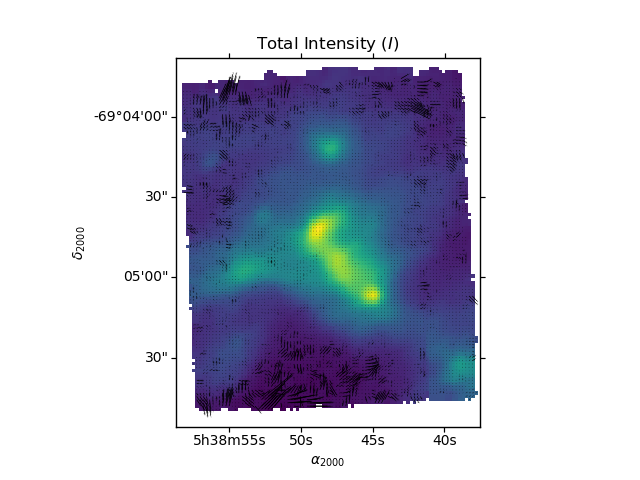

In [7]:
plt.figure()
ax = plt.subplot(projection=stokes_i.wcs)
ax.imshow(stokes_i.data,origin='lower')

# Mask out bad values?

ax.quiver(U,V,headaxislength=0)

# FORMATTING
ax.set_title('Total Intensity ($I$)')
ax.set_xlabel(r'$\alpha_{2000}$')
ax.set_ylabel(r'$\delta_{2000}$')
ax.coords[0].set_major_formatter('hh:mm:ss')
#ax.set_xlim([10,80])  # we zoom in a bit since the NaNs at the edges
#ax.set_ylim([10,80])  #  make the residuals blow up

One can certainly play around with some of the configuration options to `quiver`, such as scaling and masking out bad pixels. However, another option is binning.  To visualize some of the larger scale vector flows, we can bin both the magnitude and angle of the polarization vectors.  We do this below by downsampling and summing the magnitudes ($p$) and averaging the angles of the vectors ($\theta$) in each bin.

For demonstration purposes, we have added a little widget to show what happens when the bin size increases.

<IPython.core.display.Javascript object>


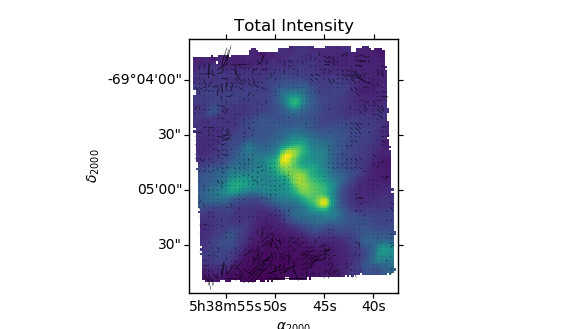

interactive(children=(IntSlider(value=2, description='block size', max=10, min=1), Output()), _dom_classes=('w…

In [8]:
from astropy.nddata.utils import block_reduce
from ipywidgets import interact, IntSlider
import warnings
warnings.filterwarnings("ignore")

fig = plt.figure()
ax = plt.subplot(projection=stokes_i.wcs)
im = ax.imshow(stokes_i.data,origin='lower')

plotted = [im]

def rebin(n=2):
    # combine nxn pixels
    mag   = block_reduce(p.data,     block_size=n, func=np.nansum)
    angle = block_reduce(theta.data, block_size=n, func=np.nanmean)

    # Compute U,V  (x,y components of polarization arrow vectors)
    U = mag * np.cos(angle*np.pi/180)  # argument to numpy trig functions must be in radians
    V = mag * np.sin(angle*np.pi/180)

    # We cannot simply plot U and V anymore because these arrays are now much smaller
    #   than the background image
    # We can either downsample the Stokes I image as well, or we can alter the spacing of the 
    #   U and V vector coordinates

    Y,X = np.mgrid[0:mag.shape[0]*n:n,
                   0:mag.shape[1]*n:n]   ##!! [this is potentially misaligned?]

    ## this is just for the interactive widget
    if len(plotted) == 2:
        plotted.pop().remove()
        
    lines = ax.quiver(X,Y,U,V,headaxislength=0)
    plotted.append(lines)  # store for removing if widget is updated
    
widget = interact(rebin,
             n=IntSlider(min=1,max=10,step=1,value=2,description='block size'))

# FORMATTING
ax.set_title('Total Intensity')
ax.set_xlabel(r'$\alpha_{2000}$')
ax.set_ylabel(r'$\delta_{2000}$')
ax.coords[0].set_major_formatter('hh:mm:ss')

# Streamlines

Another method of visualizing the polarization vectors is by using "Planck-style" streamlines, an example of which is shown in the SOFIA 30 Doradus [press release](https://www.sofia.usra.edu/multimedia/science-results-archive/sofia-reveals-never-seen-magnetic-field-details).

We can create a similar figure ourselves using method called [Line Integral Convolution](https://en.wikipedia.org/wiki/Line_integral_convolution), which is often used in MHD simulations to visualize vector-field data.  For our SOFIA data, we have created a very simple python module based on both a [Scipy cookbook recipe](https://scipy-cookbook.readthedocs.io/items/LineIntegralConvolution.html), and the astrophysical dynamics code [yt-project](https://yt-project.org/).  As long as [Cython](https://cython.readthedocs.io/en/latest/src/quickstart/install.html) is available in your python environment, the SOFIA variant of Line Integral Convolution [liccy](https://github.com/msgordon/liccy), can be installed with `pip`:

```console
foo@bar:~$ pip install git+https://github.com/msgordon/liccy.git
```

Before we can apply this method, though, we need to upsample our data a bit.  We define the following method, where `block` represents the upsampling factor:

In [9]:
from scipy.interpolate import griddata

def upsample(data,block, method='cubic'):
    # generate grid of (indices, values) for our data
    points,values = zip(*np.ndenumerate(data))
    points = np.array(points)
    values = np.array(values)

    # these grids represent the new, upsample indices to interpolate onto
    grid_x,grid_y = np.mgrid[0:data.shape[0]:data.shape[0]*block*1j,
                             0:data.shape[1]:data.shape[1]*block*1j]

    # we want to effectively mask out the NaNs in our data before interpolating
    real_idx = np.array([~np.isnan(v) for v in values])

    points = points[real_idx]
    values = values[real_idx]

    # pf stores our new upsampled/interpolated array
    pf = griddata(points,values,(grid_x,grid_y),method=method)
    return pf

We additionally define another function as the client for liccy.

In [10]:
from liccy import line_integral_convolution_2d

def lic(U,V,shape,kernellen=50,texture=None):
    # U,V are the x,y components of the polarization vectors
    # shape is the size of the upsampled array
    # kernellen is the size of the convolution kernel
    # texture will be a randomly generated array of pixels that will "flow" across the vector field
    
    if texture is None:
        texture = np.random.rand(shape[0],shape[1]).astype(np.double)
    
    kernel = np.sin(np.arange(kernellen)*np.pi/kernellen)
    
    # combine U,V to one vector field
    vectors = np.concatenate((U[...,np.newaxis],
                              V[...,np.newaxis]),axis=2)
    
    # perform the line integral convolution and return normalized image of the resulting vector field
    lic_data = line_integral_convolution_2d(vectors, texture, kernel)
    lic_data = lic_data / np.nanmax(lic_data)
    
    return lic_data

Finally, we can upsample our polarization vectors and run the convolution:

<IPython.core.display.Javascript object>


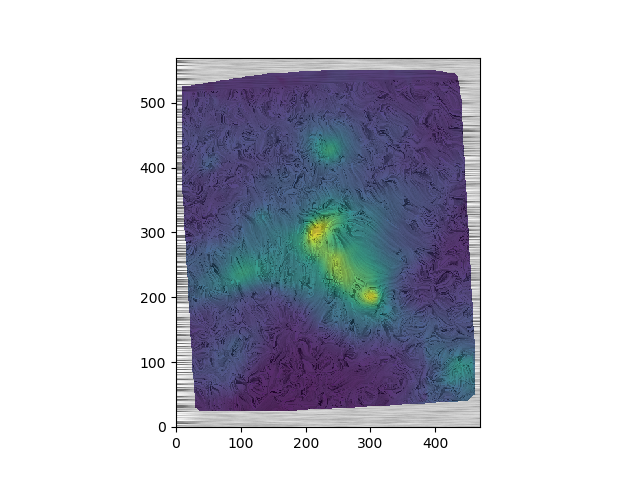

In [11]:
block = 5        # upsample by a factor of 5
alpha = 0.75     # the relative transparency of the vectors to the flux image
cmap = 'binary'  # grayscale colormap for the vectors

stokes_if = upsample(stokes_i.data, block)  # stokes i upsampled
pf = upsample(p.data, block)                # debiased polarization upsampled
tf = upsample(theta.data, block)            # rotated pol angle upsampled

# x,y components of polarization vectors
U = pf*np.cos(tf*np.pi/180)
V = pf*np.sin(tf*np.pi/180)

# perform the convolution
lic_data = lic(U,V,stokes_if.shape)

# clip off the largest vectors
lim = (0,0.8)   # clip off the top quintile (largest 20%) of the vectors
lic_data_clip = np.clip(lic_data,lim[0],lim[1])

# use a grayscale colormap to represent the magnitude of the vectors
from matplotlib import cm
lic_data_rgba = cm.ScalarMappable(norm=None,cmap=cmap).to_rgba(lic_data_clip)

# renormalize our vector field to the defined limits
lic_data_clip_rescale = (lic_data_clip - lim[0]) / (lim[1] - lim[0])
lic_data_rgba[...,3] = lic_data_clip_rescale * alpha

# plot our Stokes I intensity image with the vectors overlaid
plt.figure()
ax = plt.imshow(stokes_if,origin='lower')
ax = plt.imshow(lic_data_rgba,origin='lower',cmap=cmap,alpha=alpha)